In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf


# Suppress warnings
warnings.filterwarnings("ignore")

# For reproducibility
np.random.seed(42)

In [ ]:
def get_data(tickers, start_date='2014-06-03', end_date='2024-06-03'):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data

def preprocess_data(data):
    normalized_data = data / data.iloc[0]
    return normalized_data

In [ ]:
data = get_data(["XEL","WEC","EQR","ESS","CCL","NCLH","CMS","ETR","AVB","UDR"])
normalized_data = preprocess_data(data)
normalized_data.head()

[*********************100%%**********************]  10 of 10 completed


Ticker,AVB,CCL,CMS,EQR,ESS,ETR,NCLH,UDR,WEC,XEL
Date,,,,,,,,,,
2014-06-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2014-06-04,1.001897,0.998257,1.000000,0.998874,1.005580,1.005117,1.002058,1.001805,1.002644,1.001956
2014-06-05,1.014329,1.000747,1.011417,1.015756,1.023537,1.031357,1.000294,1.019495,1.010575,1.010104
2014-06-06,1.001335,1.002241,1.011417,1.007235,1.019559,1.028733,0.992357,1.011553,1.008152,1.015971
2014-06-09,0.982791,1.009711,1.001679,0.992283,1.004531,1.032406,0.990006,0.991336,1.003084,1.010430


In [ ]:
def calculate_spread(y, x):
    model = sm.OLS(y, sm.add_constant(x)).fit()
    spread = y - model.predict(sm.add_constant(x))
    return spread, model.params

# test sationary
def adf_test(series):
    result = adfuller(series)
    return result[1]  # Return p-value

In [ ]:
def generate_signals(spread, forecasted_spread, mean, std, entry_threshold=2, exit_threshold=0):
    upper_threshold = mean + entry_threshold * std
    lower_threshold = mean - entry_threshold * std

    signals = pd.Series(index=spread.index)

    signals[forecasted_spread > upper_threshold] = -1
    signals[forecasted_spread < lower_threshold] = 1
    signals[abs(spread - mean) < exit_threshold * std] = 0
    signals.ffill(inplace=True)
    print("lower_threshold, upper_threshold")
    print(lower_threshold, upper_threshold)
    print(forecasted_spread)
    return signals

In [ ]:
def select_arima_model(series):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p in range(0,10):
          for q in range(0,6):
              try:
                  model = ARIMA(series, order=(p,0,q)).fit()
                  print(p,q,model.aic)
                  if model.aic < best_aic:
                      best_aic = model.aic
                      best_order = (p,0,q)
                      best_model = model

              except:
                  continue




    print(best_order)

    model_params = best_order
    return best_model, model_params

In [ ]:
pairs = [("XEL","WEC"),("EQR","ESS"),("CCL","NCLH"),("CMS","ETR"),("AVB","UDR")]


In [ ]:
pairs_d1 = [("CCL","NCLH"),("AVB","UDR")]
pairs_d0 = [("XEL","WEC"),("EQR","ESS"),("CMS","ETR")]
for pair in pairs_d0:
    spread, _ = calculate_spread(normalized_data[pair[0]], normalized_data[pair[1]])
    model, params = select_arima_model(spread)
    print(f"Best ARIMA model for {pair}: Order = {params}, AIC = {model.aic}")


0 0 -6035.226215001414
0 1 -8709.17528634293
0 2 -10446.415597946096
0 3 -11269.72529401016
0 4 -11889.488429505767
0 5 -12261.543863509041
1 0 -13279.789633605084
1 1 -13287.840698372787
1 2 -13287.52576873748
1 3 -13303.473346506653
1 4 -13301.712445641677
1 5 -13310.076608811774
2 0 -13288.2634980939
2 1 -13285.622410791533
2 2 -13285.873945297528
2 3 -13301.46658211749
2 4 -13299.579625159946
2 5 -13307.82575393019
3 0 -13286.673731304902
3 1 -13288.919213391899
3 2 -13284.86938132404
3 3 -13304.085048312923
3 4 -13300.845688231937
3 5 -13308.698655803477
4 0 -13304.945546650837
4 1 -13302.682751100028
4 2 -13300.349126375804
4 3 -13302.477591494146
4 4 -13305.117593912473
4 5 -13310.060450061515
5 0 -13302.957163286655
5 1 -13301.695918849693
5 2 -13295.042681095956
5 3 -13301.396958990434
5 4 -13308.654076610914
5 5 -13308.302027022355
6 0 -13309.122528908303
6 1 -13306.234624919962
6 2 -13305.734040177373
6 3 -13298.456742724942
6 4 -13308.874289113697
6 5 -13307.433888984313
7 

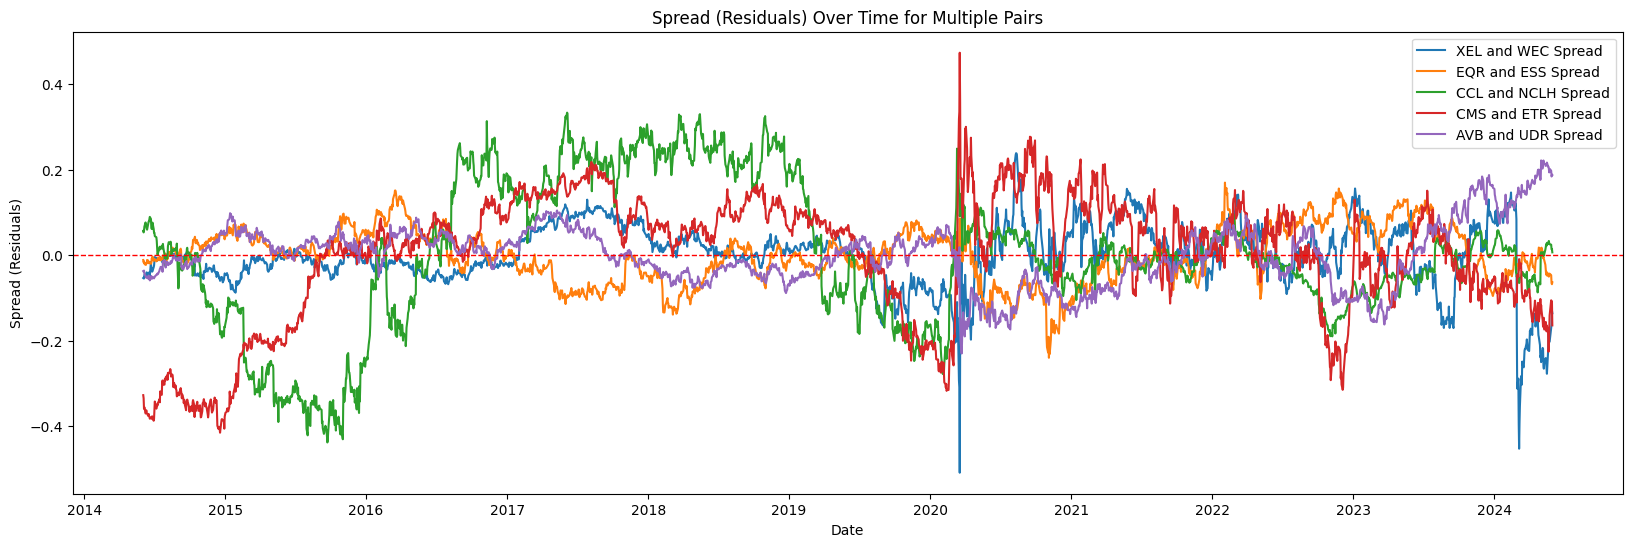

In [ ]:
spreads = {}
plt.figure(figsize=(20, 6))
for pair in pairs:
    stock1, stock2 = pair
    spread, params = calculate_spread(normalized_data[stock1], normalized_data[stock2])
    spreads[pair] = {
        'spread': spread,
    }
    plt.plot(spread.index, spread.values, label=f'{stock1} and {stock2} Spread')


plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Spread (Residuals)')
plt.title('Spread (Residuals) Over Time for Multiple Pairs')
plt.legend()
plt.show()
#spread, params = calculate_spread(normalized_data[pairs[0][0]], normalized_data[pairs[0][1]])

#_, model_params = select_arima_model(spread, use_SARIMAX=False)

In [ ]:
spread.head()

Date
2014-06-03   -0.053582
2014-06-04   -0.054432
2014-06-05   -0.054705
2014-06-06   -0.046265
2014-06-09   -0.046426
dtype: float64

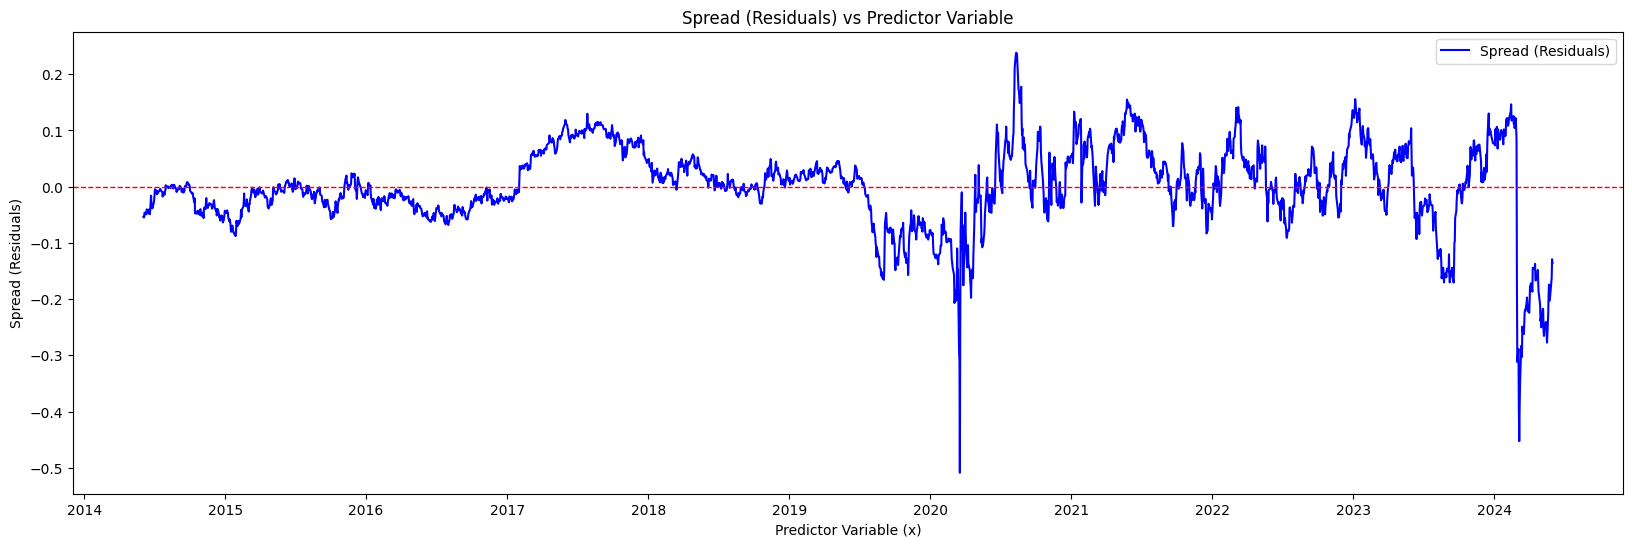

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(spread.index, spread,color='blue', label='Spread (Residuals)')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predictor Variable (x)')
plt.ylabel('Spread (Residuals)')
plt.title('Spread (Residuals) vs Predictor Variable')
plt.legend()
plt.show()

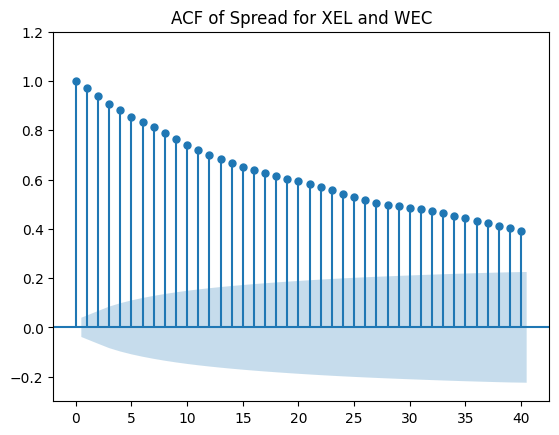

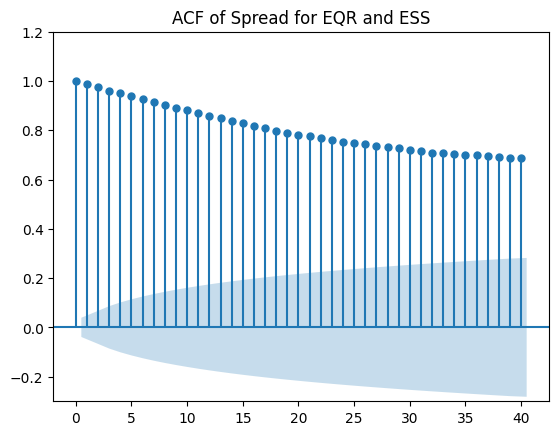

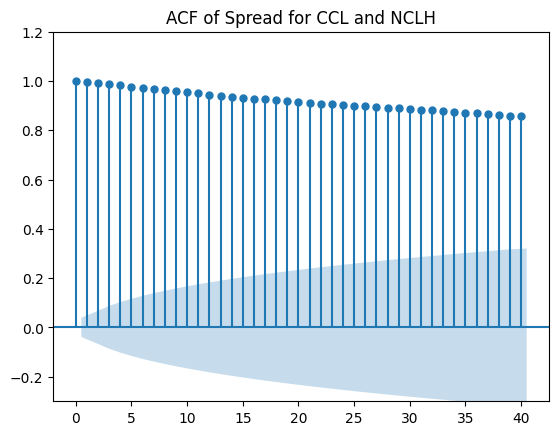

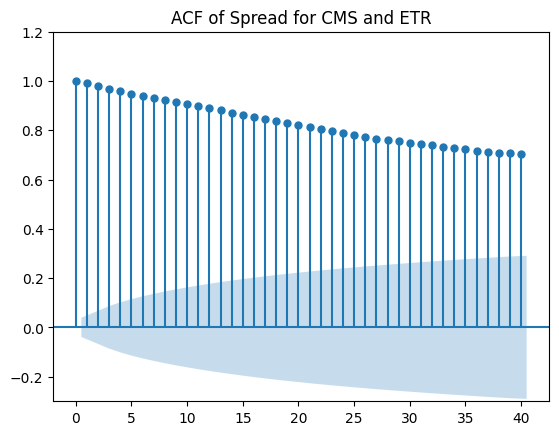

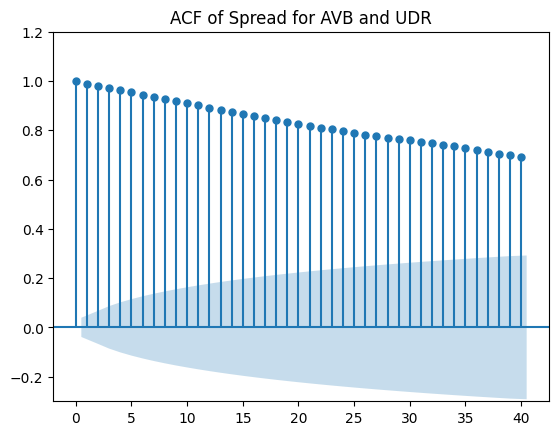

In [ ]:


# Plot ACF for each pair
for pair in pairs:
    spread = spreads[pair]['spread']
    plot_acf(spread, lags=40, alpha=0.05, title=f'ACF of Spread for {pair[0]} and {pair[1]}')

    plt.ylim(-0.3, 1.2)
    plt.show()



In [ ]:
for pair, data in spreads.items():
    spread_series = data['spread']
    df = spread_series.to_frame(name='spread')
    # Create a filename based on the pair
    filename = f'{pair[0]}_{pair[1]}_spread.csv'

    # Save the DataFrame to a CSV file
    df.to_csv(filename)




In [ ]:
import statsmodels.api as sm

sm.graphics.tsa.month_plot(spread)
plt.show()

AttributeError: 'NoneType' object has no attribute 'startswith'

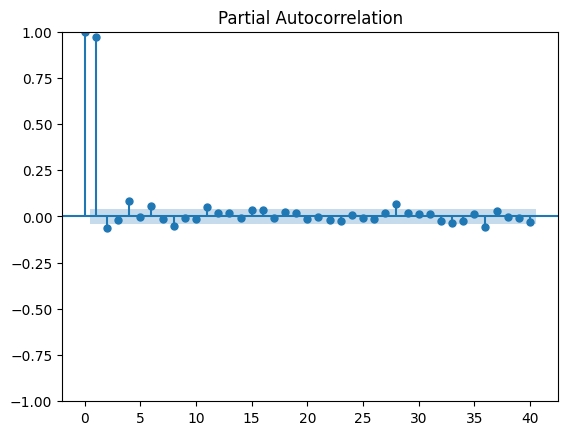

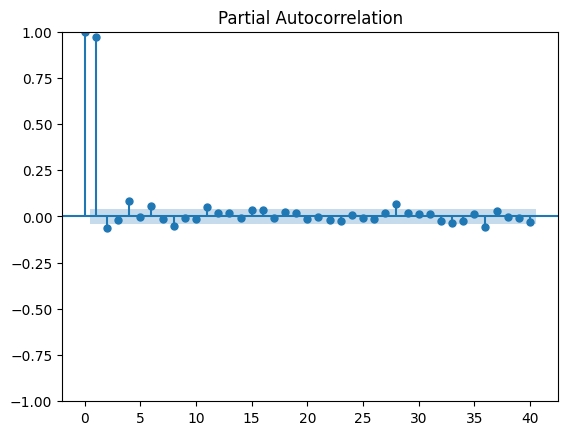

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(spread,lags=40)

In [ ]:
def plot_model_acf(residuals,p,d,q):
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_acf(residuals, ax=ax, lags=40)
    plt.ylim(-0.25,1)
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation Function for ARIMA({p},{d},{q})')
    plt.show()

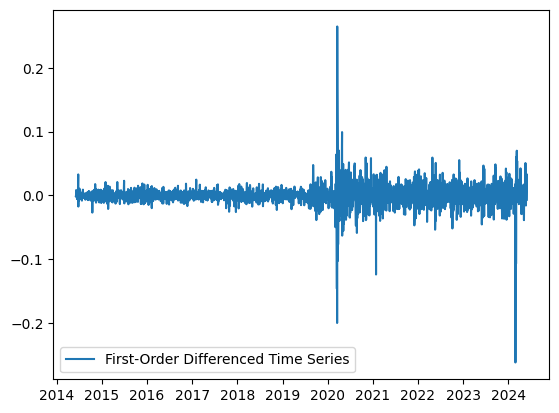

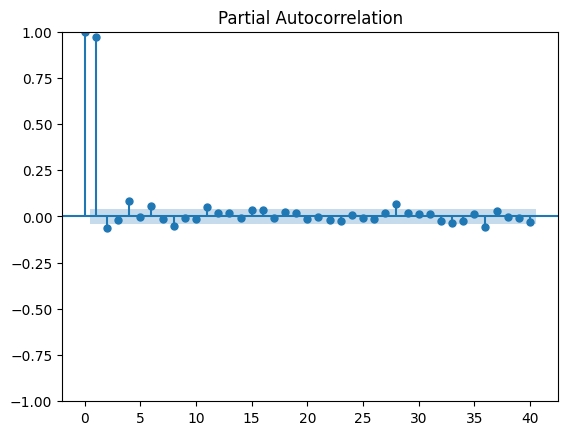

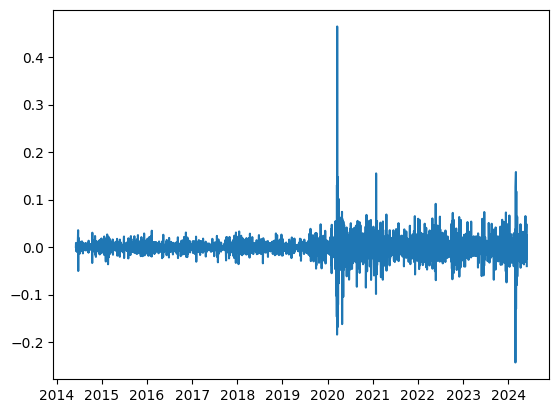

In [ ]:
first_order_diff = spread.diff().dropna()
second_order_diff = first_order_diff.diff().dropna()
plt.plot(first_order_diff, label='First-Order Differenced Time Series')
plt.legend()
plt.show()
plot_pacf(spread,lags=40)
plt.show()
plt.plot(second_order_diff, label='First-Order Differenced Time Series')
plt.show()

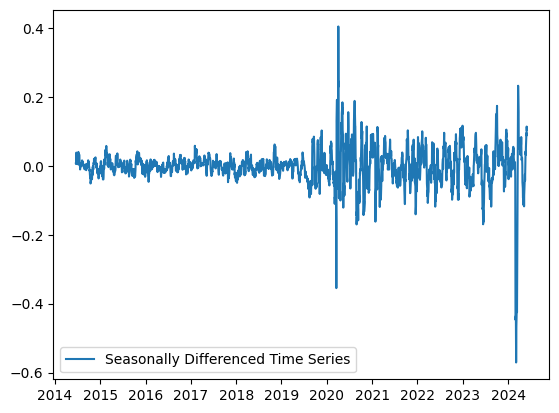

In [ ]:
seasonal_diff = spread.diff(periods = 12).dropna()
plt.plot(seasonal_diff, label='Seasonally Differenced Time Series')
plt.legend()

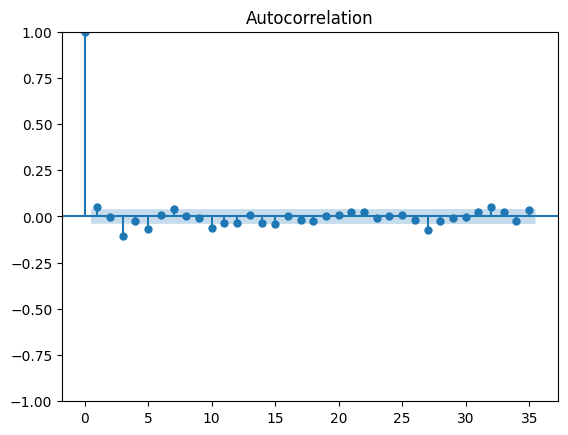

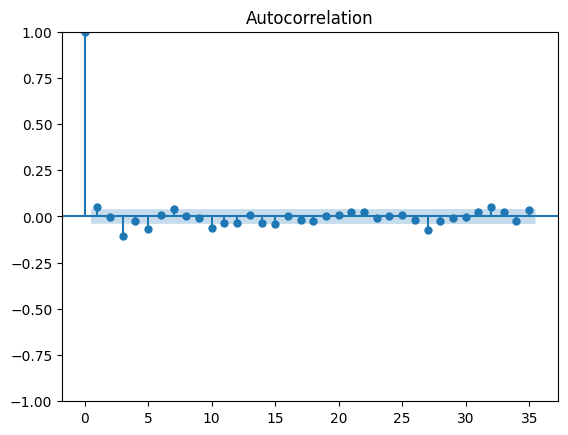

In [ ]:
 plot_acf(first_order_diff)

In [ ]:
model = ARIMA(spread, order=(3,0,3)).fit()


In [ ]:
def select_arima_model_bic(series, use_SARIMAX=True):
    best_bic = np.inf
    best_order = None
    best_model = None

    for p in range(1, 4):
        for d in range(2):
            for q in range(1, 4):
                try:
                    model = ARIMA(series, order=(p,d,q)).fit()
                    if model.bic < best_bic:
                        best_bic = model.bic
                        best_order = (p,d,q)
                        best_model = model
                except:
                    continue

    best_seasonal_order = None

    if use_SARIMAX:
        for p in range(1, 3):
            for d in range(2):
                for q in range(1, 3):
                    for P in range(0, 2):
                        for D in range(0, 2):
                            for Q in range(0, 2):
                                model = SARIMAX(series, order=(p,d,q), seasonal_order=(P,D,Q,12)).fit(disp=False)
                                if model.bic < best_bic:
                                    best_bic = model.bic
                                    best_order = (p,d,q)
                                    best_seasonal_order = (P,D,Q,12)
                                    best_model = model

    print(best_order)
    print(best_seasonal_order)

    model_params = (best_order, best_seasonal_order)
    return best_model, model_params

In [ ]:
_,aic_params = select_arima_model(spread,use_SARIMAX=True)

(3, 0, 3)
None


In [ ]:
bic_model,bic_params = select_arima_model_bic(spread, use_SARIMAX=True)

(1, 0, 1)
(0, 0, 0, 12)


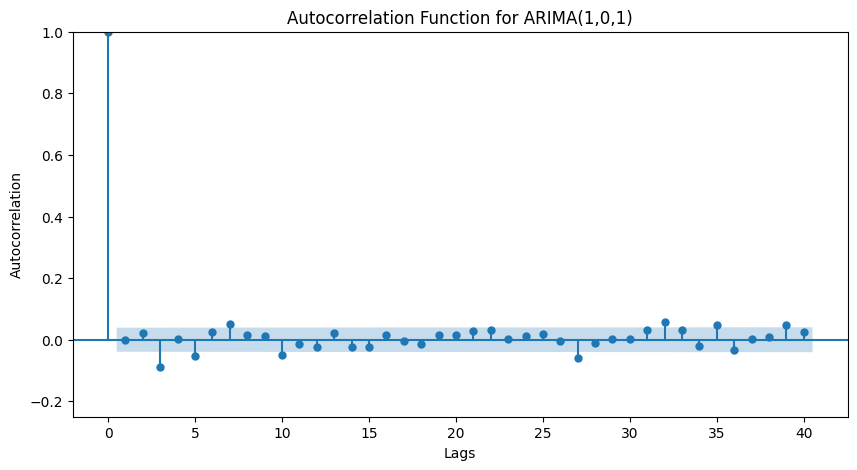

In [ ]:
plot_model_acf(bic_model.resid,1,0,1)


In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
def plot_model_pacf(residuals):
    fig, ax = plt.subplots(figsize=(10, 5))


    plot_pacf(residuals,ax=ax lags=40, alpha=0.05)  # Using 40 lags and a 95% confidence interval
    plt.title('Partial Autocorrelation Function')
    plt.xlabel('Lags')
    plt.ylabel('Partial Autocorrelation')
    plt.ylim(-0.25,1)
    plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-50-dd22b4a87b9d>, line 6)

<Figure size 1000x500 with 0 Axes>

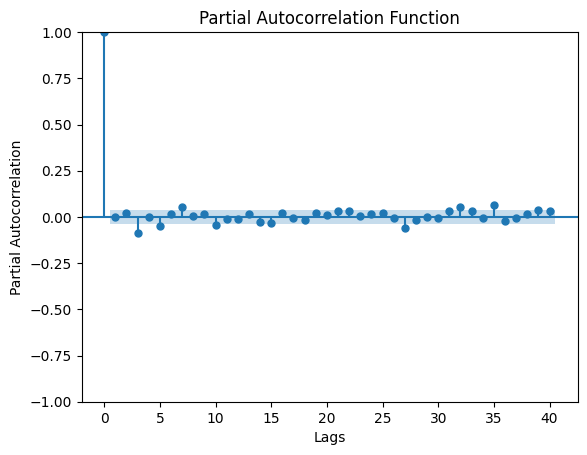

In [ ]:
plot_model_pacf(bic_model.resid)

<Figure size 640x480 with 0 Axes>

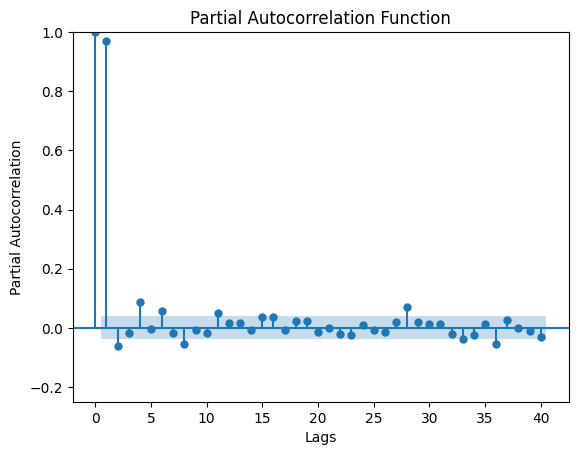

In [ ]:
plot_model_pacf(spread)



In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2517
Model:                 ARIMA(3, 0, 3)   Log Likelihood                6660.059
Date:                Wed, 05 Jun 2024   AIC                         -13304.117
Time:                        20:08:01   BIC                         -13257.471
Sample:                             0   HQIC                        -13287.188
                               - 2517                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.014     -0.193      0.847      -0.029       0.024
ar.L1          0.9446      0.088     10.682      0.000       0.771       1.118
ar.L2          0.2969      0.106      2.814      0.005       0.090       0.504
ar.L3         -0.2627      0.094     -2.793      0.005      -0.447      -0.078
ma.L1          0.0887      0.089      0.994      0.320      -0.086       0.264
ma.L2         -0.2588      0.101     -2.561      0.010      -0.457      -0.061
ma.L3         -0.1097      0.009    -12.150      0.000      -0.127      -0.092
sigma2         0.0003    2.1e-06    140.196      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):            297421.29
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               9.43   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        56.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""